# Setting

In [ ]:
import sys
import matplotlib.font_manager as fm

if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninteractive' | \
  debconf-set-selections

  !sudo apt-get -qq -y install fonts-nanum
  fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

In [ ]:
plt.rc('font', family='NanumGothic', size=10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family']
matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/mydata.db')
c = conn.cursor()

In [ ]:
from pandas import read_sql_query as sql_q, read_sql_table as sql_t

# "mydata" DB - "DATASET3" Table

In [ ]:
sql_q(
    "SELECT * FROM DATASET3;",
    conn
).head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-01-12
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-01-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-01-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-01-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-01-12
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,7.65,17850,United Kingdom,2010-01-12
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,4.25,17850,United Kingdom,2010-01-12
7,536366,22633,HAND WARMER UNION JACK,6,1.85,17850,United Kingdom,2010-01-12
8,536366,22632,HAND WARMER RED POLKA DOT,6,1.85,17850,United Kingdom,2010-01-12
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1.69,13047,United Kingdom,2010-01-12


# 지표 추출 리스트
### 1) 국가, 상품별 구매 지표
### 2) 특정 상품 구매자가 구매한 다른 상품
### 3) 국가별 재구매율 계산
### 4) 코호트 분석
### 5) 고객 Segment
### 6) 일자별 첫 구매자 수
### 7) 상품별 첫 구매 고객 수
### 8) 첫 구매 후 이탈 비중
### 9) 판매 수량이 20% 이상 증가한 상품 리스트(YTD)
### 10) 주차별 매출액
### 11) 신규 / 기존 고객의 2011년 월별 매출액 비교
### 12) 2010년 기존 고객의 2011년 월 누적 리텐션
### 13) LTV

### 1) 국가, 상품별 구매자 수 및 매출액

In [ ]:
# Result_query
sql_q(
    "SELECT COUNTRY, STOCKCODE,\
    COUNT(DISTINCT CUSTOMERID) BU,\
    SUM(QUANTITY * UNITPRICE) SALES\
    FROM DATASET3\
    GROUP BY 1,2\
    ORDER BY 3 DESC, 4 DESC;",
    conn
).head(10)

,Country,StockCode,BU,SALES
0,United Kingdom,85123A,226,20680.30
1,United Kingdom,22423,154,21209.25
2,United Kingdom,22469,137,7366.84
3,United Kingdom,22720,125,2799.00
4,United Kingdom,22961,123,2100.70
5,United Kingdom,22470,120,7964.37
6,United Kingdom,85099B,118,8583.15
7,United Kingdom,84879,117,5424.81
8,United Kingdom,22960,106,3006.00
9,United Kingdom,22457,105,2719.75


### 2) 특정 상품 구매자가 구매한 다른 상품
- 가장 많이 구매한 상품 2개를 모두 구매한 구매자가 구매한 상품별 주문건수 확인

In [ ]:
# Basic Query
sql_q(
    "SELECT *, ROW_NUMBER() OVER(ORDER BY QTY DESC) RNK\
    FROM \
    (SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    GROUP BY 1) BASE ;",
    conn
).head(10)

,STOCKCODE,QTY,RNK
0,84077,10033,1
1,85123A,7695,2
2,85099B,5151,3
3,22492,4779,4
4,22469,4173,5
5,22616,4123,6
6,21212,3908,7
7,84879,3633,8
8,21915,3540,9
9,22189,3339,10


In [ ]:
# Process Query
sql_q(
    "SELECT CUSTOMERID FROM DATASET3\
    GROUP BY 1\
    HAVING MAX(CASE WHEN STOCKCODE = '84077' THEN 1 ELSE 0 END) = 1\
    AND MAX(CASE WHEN STOCKCODE = '85123A' THEN 1 ELSE 0 END) = 1;",
    conn
).head(10)

,CustomerID
0,13488
1,14669
2,14911
3,17211


In [ ]:
# 참조 VIEW 생성
c.execute(
    "CREATE VIEW IF NOT EXISTS BU_VIEW AS\
    SELECT CUSTOMERID FROM DATASET3\
    GROUP BY 1\
    HAVING MAX(CASE WHEN STOCKCODE = '84077' THEN 1 ELSE 0 END) = 1\
    AND MAX(CASE WHEN STOCKCODE = '85123A' THEN 1 ELSE 0 END) = 1;"
)

sql_q("SELECT * FROM BU_VIEW;",conn)

,CustomerID
0,13488
1,14669
2,14911
3,17211


In [ ]:
# Result Query
sql_q(
    "SELECT DISTINCT STOCKCODE, DESCRIPTION\
    FROM DATASET3\
    WHERE CUSTOMERID IN (SELECT CUSTOMERID FROM BU_VIEW)\
    AND STOCKCODE NOT IN ('84077', '85123A');",
    conn
).head(10)

,StockCode,Description
0,22968,ROSE COTTAGE KEEPSAKE BOX
1,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN
2,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"""""""""""""""" SIGN"""""""""""""""
3,22355,CHARLOTTE BAG SUKI DESIGN
4,21579,LOLITA DESIGN COTTON TOTE BAG
5,21576,LETS GO SHOPPING COTTON TOTE BAG
6,22147,FELTCRAFT BUTTERFLY HEARTS
7,22150,3 STRIPEY MICE FELTCRAFT
8,22492,MINI PAINT SET VINTAGE
9,22493,PAINT YOUR OWN CANVAS SET


### 3) 국가별 재구매율

In [ ]:
con_ret = sql_q(
    "SELECT A.COUNTRY, SUBSTR(B.INVOICEDATE,1,4) YY,\
    (COUNT(DISTINCT B.CUSTOMERID) + 0.0) /  COUNT(DISTINCT A.CUSTOMERID) RETENTION_RATE\
    FROM\
    (SELECT DISTINCT COUNTRY, INVOICEDATE, CUSTOMERID\
    FROM DATASET3) A\
    LEFT JOIN\
    (SELECT DISTINCT COUNTRY, INVOICEDATE, CUSTOMERID\
    FROM DATASET3) B\
    ON SUBSTR(A.INVOICEDATE,1,4) = CAST(SUBSTR(B.INVOICEDATE,1,4) -1 AS TEXT)\
    AND A.COUNTRY = B.COUNTRY\
    AND A.CUSTOMERID = B.CUSTOMERID\
    GROUP BY 1,2\
    ORDER BY 3 DESC;",
    conn
)
con_ret.head(10)

,COUNTRY,YY,RETENTION_RATE
0,Australia,2011,1.0
1,Belgium,2011,1.0
2,EIRE,2011,1.0
3,France,2011,1.0
4,Germany,2011,1.0
5,Japan,2011,1.0
6,Poland,2011,1.0
7,Portugal,2011,1.0
8,Spain,2011,1.0
9,United Kingdom,2011,1.0


### 4) 코호트분석
- 기준 : 처음 구매한 월을 기준으로 다음 구매 월까지 소요되는 기간의 각 그룹 간의 패턴 파악

In [ ]:
# Basic Query
sql_q(
    "SELECT CUSTOMERID, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1;",
    conn
).head(10)

,CustomerID,MNDT
0,12347,2010-07-12
1,12350,2011-02-02
2,12352,2011-01-03
3,12359,2011-07-02
4,12373,2011-01-02
5,12383,2011-12-01
6,12386,2010-08-12
7,12388,2011-07-02
8,12393,2011-11-01
9,12395,2010-03-12


In [ ]:
sql_q(
    "SELECT CUSTOMERID,INVOICEDATE,\
    UNITPRICE*QUANTITY SALES\
    FROM DATASET3",
    conn
).head(10)

,CustomerID,InvoiceDate,SALES
0,17850,2010-01-12,15.30
1,17850,2010-01-12,20.34
2,17850,2010-01-12,22.00
3,17850,2010-01-12,20.34
4,17850,2010-01-12,20.34
5,17850,2010-01-12,15.30
6,17850,2010-01-12,25.50
7,17850,2010-01-12,11.10
8,17850,2010-01-12,11.10
9,13047,2010-01-12,54.08


In [ ]:
# Result Query
mondiff_df = sql_q(
    "SELECT SUBSTR(MNDT,1,7) MM,\
    ROUND((JULIANDAY(B.INVOICEDATE) - JULIANDAY(MNDT)) / 30) MONTHDIFF,\
    COUNT(DISTINCT A.CUSTOMERID) BU,\
    SUM(SALES) SALES\
    FROM\
    (SELECT CUSTOMERID, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1) A\
    LEFT JOIN\
    (SELECT CUSTOMERID,INVOICEDATE,\
    UNITPRICE*QUANTITY SALES\
    FROM DATASET3) B\
    ON A.CUSTOMERID = B.CUSTOMERID\
    GROUP BY 1,2;",
    conn
)
mondiff_df.head(10)

,MM,MONTHDIFF,BU,SALES
0,2010-01,0.0,95,46376.49
1,2010-01,1.0,6,4861.22
2,2010-01,2.0,4,3795.89
3,2010-01,4.0,5,2701.55
4,2010-01,5.0,7,4544.86
5,2010-01,6.0,3,2220.51
6,2010-01,7.0,10,4410.07
7,2010-01,8.0,7,3315.62
8,2010-01,9.0,5,3384.91
9,2010-01,12.0,6,8247.58


- 다음 구매월까지의 소요되는 기간을 기준으로 매출액을 분석할 필요 있음

In [ ]:
p_mdiff = mondiff_df.pivot_table(index='MONTHDIFF', values=['BU', 'SALES'], aggfunc=['sum','mean'])
p_mdiff.columns

MultiIndex([( 'sum',    'BU'),
            ( 'sum', 'SALES'),
            ('mean',    'BU'),
            ('mean', 'SALES')],
           )

In [ ]:
p_mdiff = p_mdiff.iloc[:,[0,3]]
p_mdiff.columns = ['BU', 'SALES']
p_mdiff

,BU,SALES
MONTHDIFF,,
0.0,1183,25888.687273
1.0,18,1317.810000
2.0,18,954.804167
3.0,16,1125.997000
4.0,23,797.883333
5.0,30,1208.035455
6.0,30,779.113077
7.0,42,1603.621111
8.0,35,2166.703000


In [ ]:
p_mdiff['Per Sales'] = p_mdiff['SALES'] / p_mdiff['BU']
p_mdiff.head(10)

,BU,SALES,Per Sales
MONTHDIFF,,,
0.0,1183,25888.687273,21.883928
1.0,18,1317.810000,73.211667
2.0,18,954.804167,53.044676
3.0,16,1125.997000,70.374812
4.0,23,797.883333,34.690580
5.0,30,1208.035455,40.267848
6.0,30,779.113077,25.970436
7.0,42,1603.621111,38.181455
8.0,35,2166.703000,61.905800


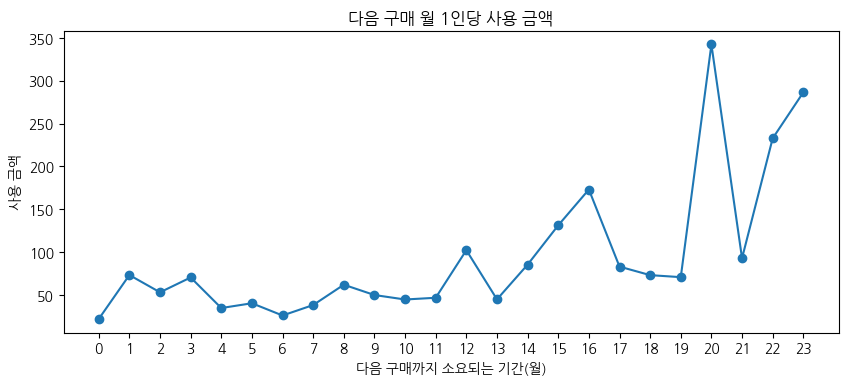

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(p_mdiff.index, p_mdiff['Per Sales'])
plt.plot(p_mdiff.index, p_mdiff['Per Sales'])
plt.xticks(p_mdiff.index)
plt.title('다음 구매 월 1인당 사용 금액')
plt.xlabel('다음 구매까지 소요되는 기간(월)')
plt.ylabel('사용 금액')
plt.savefig('next_persale.png')
plt.show()

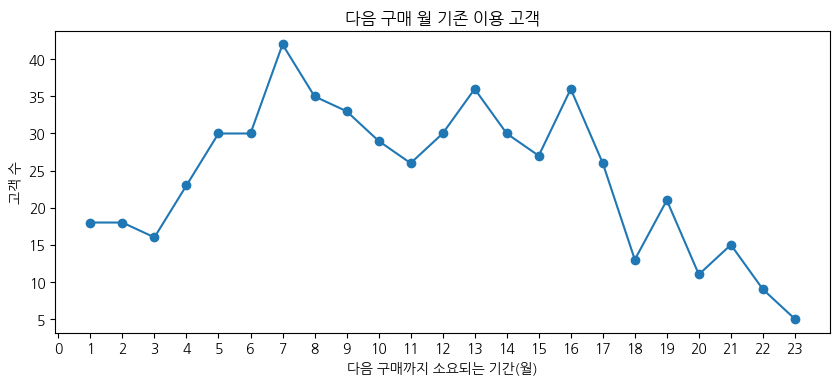

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(p_mdiff.index[1:], p_mdiff['BU'][1:])
plt.plot(p_mdiff.index[1:], p_mdiff['BU'][1:])
plt.xticks(p_mdiff.index)
plt.title('다음 구매 월 기존 이용 고객')
plt.xlabel('다음 구매까지 소요되는 기간(월)')
plt.ylabel('고객 수')
plt.savefig('next_cus.png')
plt.show()

### 5) 고객 Segment
>(1) RFM : 높은 가치를 가진 고객을 구분
- R : Recency : 최근 구입한 시기
- F : Frequency : 얼마나 자주 구입했는지 빈도
- M : Monetary : 구입한 총 금액
- 데이터셋의 마지막 구매 일자 : 2011-12-01
- 기준일자 : 2011-12-02


>(2) 재구매 Segment : 동일한 상품을 2개 연도에 걸쳐서 구매한 고객과 그렇지 않은 고객을 분할

#### (1) RFM

In [ ]:
# Basic Query
sql_q(
    "SELECT CUSTOMERID, MAX(INVOICEDATE) MXDT\
    FROM DATASET3\
    GROUP BY 1;",
    conn
).head(10)

,CustomerID,MXDT
0,12347,2010-07-12
1,12350,2011-02-02
2,12352,2011-01-03
3,12359,2011-12-01
4,12373,2011-01-02
5,12383,2011-12-01
6,12386,2011-06-01
7,12388,2011-07-02
8,12393,2011-11-01
9,12395,2011-11-02


In [ ]:
# Recency
sql_q(
    "SELECT CUSTOMERID,\
    ( JULIANDAY('2011-12-02') - JULIANDAY(MXDT) ) recency\
    FROM \
    (SELECT *, MAX(INVOICEDATE) MXDT\
    FROM DATASET3\
    GROUP BY 1) BASE\
    ORDER BY 2;",
    conn
).head(10)

,CustomerID,recency
0,14270,1.0
1,12523,1.0
2,16353,1.0
3,16655,1.0
4,16779,1.0
5,16359,1.0
6,17965,1.0
7,15953,1.0
8,17324,1.0
9,12712,1.0


In [ ]:
# Frequency, Monetory
sql_q(
    "SELECT CUSTOMERID,\
    COUNT(DISTINCT INVOICENO) Frequency,\
    SUM(QUANTITY*UNITPRICE) Monetary\
    FROM DATASET3\
    GROUP BY 1;",
    conn
).head(10)

,CustomerID,Frequency,Monetary
0,12347,1,711.79
1,12350,1,334.40
2,12352,2,984.65
3,12359,2,2386.41
4,12373,1,364.60
5,12383,1,651.16
6,12386,2,401.90
7,12388,1,124.05
8,12393,1,462.50
9,12395,2,577.61


In [ ]:
# RFM Result Query
clu_df = sql_q(
    "SELECT CUSTOMERID,\
    ( JULIANDAY('2011-12-02') - JULIANDAY(MXDT) ) Recency,\
    Frequency, Monetary\
    FROM \
    (SELECT CUSTOMERID,\
    MAX(INVOICEDATE) MXDT, \
    COUNT(DISTINCT INVOICENO) Frequency,\
    SUM(QUANTITY*UNITPRICE) Monetary\
    FROM DATASET3\
    GROUP BY 1) BASE\
    ORDER BY 4 DESC, 3, 2;",
    conn
)
clu_df.head(10)

,CUSTOMERID,Recency,Frequency,Monetary
0,18102,153.0,7,39766.09
1,12415,62.0,3,23819.82
2,15749,31.0,2,22998.40
3,17450,31.0,6,22748.74
4,15061,1.0,17,19576.46
5,17511,215.0,4,11779.70
6,15311,1.0,15,9568.17
7,12753,91.0,3,9341.13
8,17381,61.0,9,9141.82
9,15769,152.0,4,8233.68


##### a) 군집분석

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
scale_data = scaler.fit_transform(clu_df[['Recency','Frequency','Monetary']])

In [ ]:
for pca_n in range(1,4):
  pca = PCA(n_components=pca_n)
  pca.fit(scale_data)

  total_var = sum(pca.explained_variance_ratio_)
  if total_var >= 0.80:
    print(f'주성분 {pca_n}개 분산 기여율 : {pca.explained_variance_ratio_}\n누적 기여울 : {sum(pca.explained_variance_ratio_)}\n')
    break

주성분 2개 분산 기여율 : [0.5249761  0.28762869]
누적 기여울 : 0.8126047909527325



In [ ]:
pca = PCA(n_components=2)
pca.fit(scale_data)
pca_data = pca.transform(scale_data)

pca_df = pd.DataFrame(data=pca_data, columns=['pc1', 'pc2'])

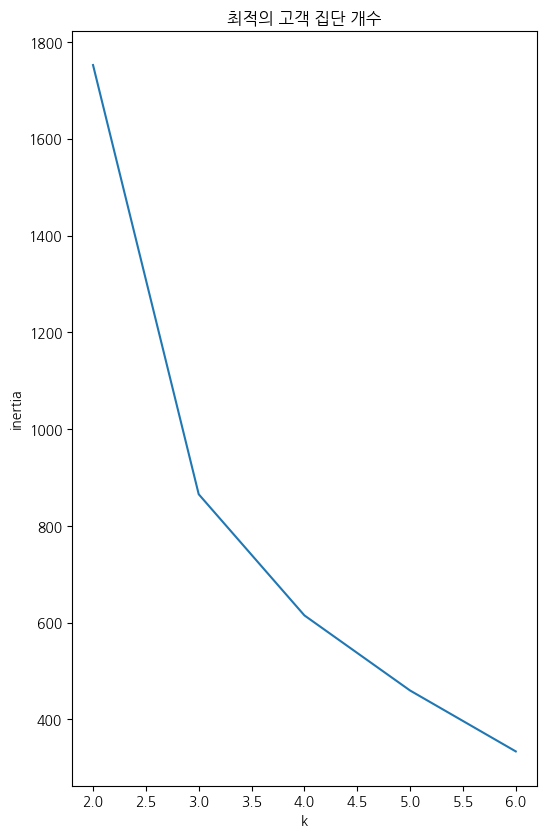

In [ ]:
inertia = []
for k in range(2,7):
  km = KMeans(n_clusters=k, random_state = 42)
  km.fit(pca_data)
  inertia.append(km.inertia_)

plt.figure(figsize=(6,10))
plt.plot(range(2,7), inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('최적의 고객 집단 개수')
plt.savefig('최적의k.png')
plt.show()

In [ ]:
km = KMeans(n_clusters=4, random_state = 42)
km.fit(pca_data)

km.labels_

array([3, 3, 3, ..., 1, 1, 1], dtype=int32)

In [ ]:
pca_df['label'] = km.labels_
pca_df.head(10)

,pc1,pc2,label
0,14.336285,7.666365,3
1,8.169394,3.642058,3
2,7.632489,3.217412,3
3,8.949708,3.681311,3
4,11.862884,4.340147,3
5,4.429338,2.092767,2
6,8.045263,2.130729,3
7,3.592094,0.943961,2
8,5.688281,1.542196,2
9,3.461927,1.123988,2


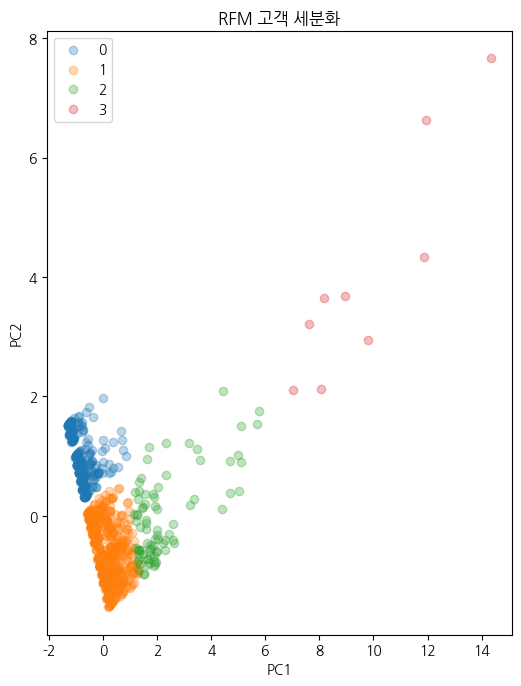

In [ ]:
plt.figure(figsize=(6,8))
for label in range(0,4):
  data = pca_df.loc[pca_df['label'] == label]
  plt.scatter(data.iloc[:,0], data.iloc[:,1], alpha=0.3)
plt.legend(range(0,4))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('RFM 고객 세분화')
plt.savefig('고객 세분화.png')
plt.show()

In [ ]:
clu_r_df = clu_df.copy()
clu_r_df['label'] = km.labels_
clu_r_df

,CUSTOMERID,Recency,Frequency,Monetary,label
0,18102,153.0,7,39766.09,3
1,12415,62.0,3,23819.82,3
2,15749,31.0,2,22998.40,3
3,17450,31.0,6,22748.74,3
4,15061,1.0,17,19576.46,3
...,...,...,...,...,...
1178,15885,275.0,1,15.00,1
1179,15823,658.0,1,15.00,0
1180,17027,333.0,1,13.20,1
1181,15224,355.0,1,11.60,1


In [ ]:
pivot_df = clu_r_df.pivot_table(index='label', values='CUSTOMERID', aggfunc='count')
pivot_df

,CUSTOMERID
label,
0,390
1,702
2,82
3,9


In [ ]:
pivot_df.reset_index().values

array([[  0, 390],
       [  1, 702],
       [  2,  82],
       [  3,   9]])

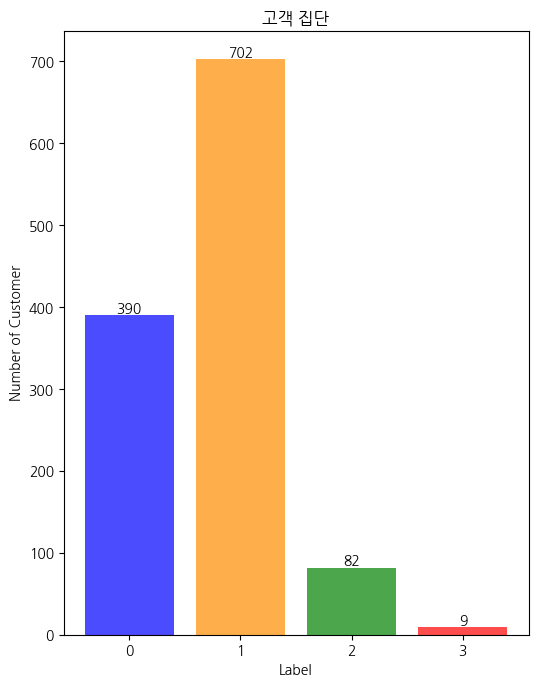

In [ ]:
plt.figure(figsize=(6,8))
plt.bar(clu_r_df['label'].value_counts().keys(), clu_r_df['label'].value_counts().values, color=['darkorange', 'blue', 'green', 'red'], alpha=0.7)
plt.xticks(range(0,4))
plt.xlabel('Label')
plt.ylabel('Number of Customer')
plt.title('고객 집단')

for idx, val in pivot_df.reset_index().values:
  plt.annotate(val, (idx,val), xytext=(0,2), textcoords='offset points',
                       fontsize=10, ha='center', color='black')
plt.savefig('고객집단.png')
plt.show()

In [ ]:
group = clu_r_df[['Recency','Frequency','Monetary','label']]
group = group.groupby('label').mean().reset_index()
group

,label,Recency,Frequency,Monetary
0,0,545.089744,1.179487,371.526282
1,1,183.263533,1.417379,497.402536
2,2,101.524390,4.804878,2946.458780
3,3,127.777778,13.777778,17298.667778


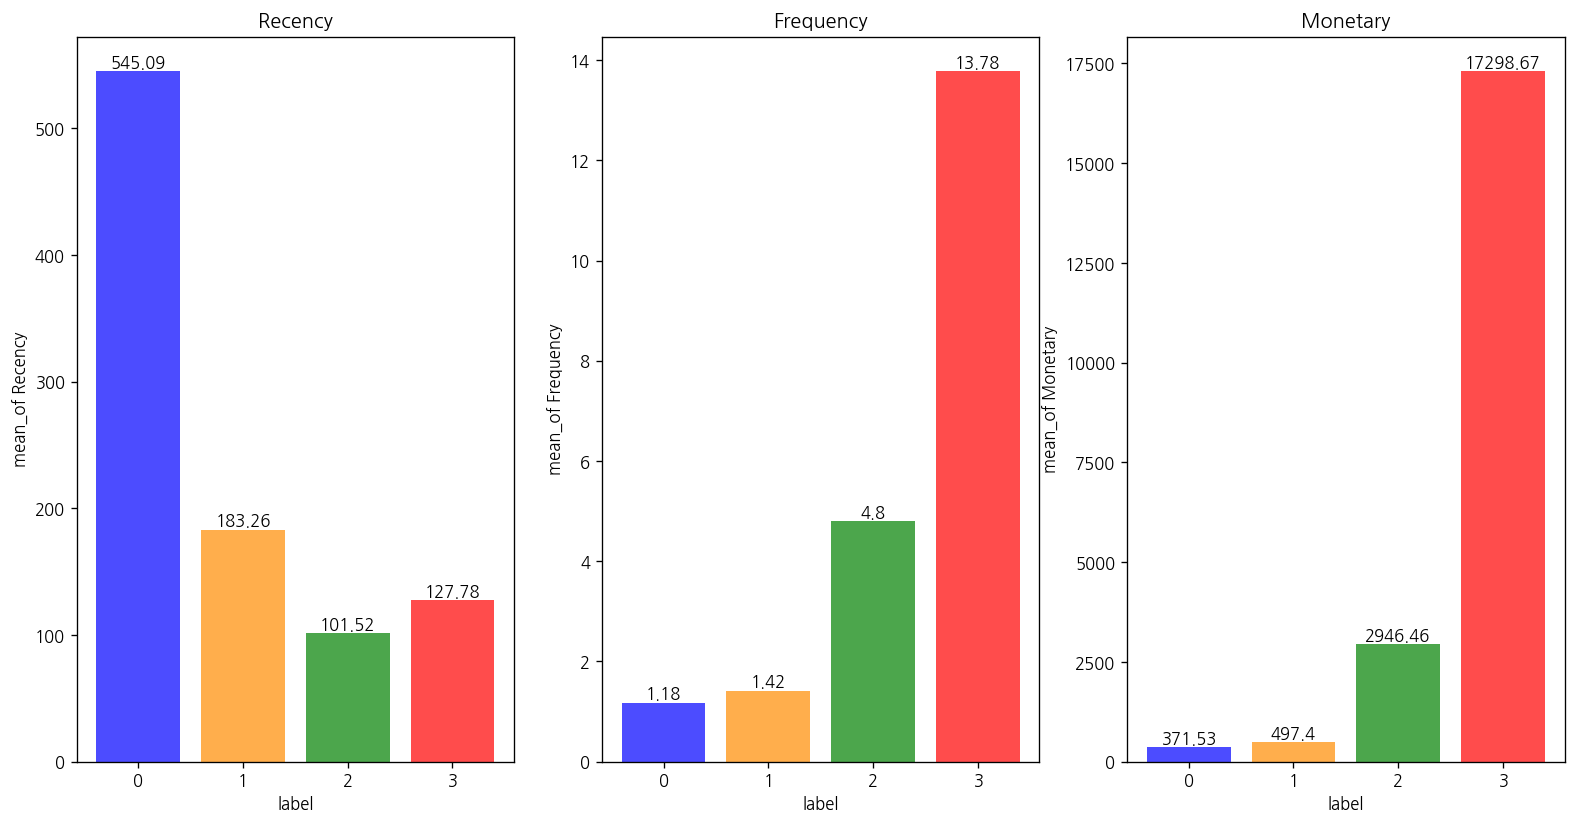

In [ ]:
plt.rcParams['figure.dpi'] = 120

fig, axes = plt.subplots(1,3, figsize=(16,8))

for i in range(1,4):
  axes[i-1].bar(group['label'], group[group.columns[i]], color = ['blue','darkorange', 'green', 'red'], alpha=0.7)
  axes[i-1].set_title(group.columns[i])
  axes[i-1].set_xticks(range(0,4))
  axes[i-1].set_xlabel('label')
  axes[i-1].set_ylabel(f'mean_of {group.columns[i]}')
  for idx, val in group[group.columns[i]].items():
    axes[i-1].annotate(np.round(val,2), (idx,val), xytext=(0,2), textcoords='offset points',
                       fontsize=10, ha='center', color='black')
fig.savefig('RFM.png')
fig.show()

#### (2) 재구매 Segment

In [ ]:
# Basic Query
sql_q(
    "SELECT CUSTOMERID, STOCKCODE,\
    COUNT(DISTINCT SUBSTR(INVOICEDATE, 1, 4)) unique_yy\
    FROM DATASET3\
    GROUP BY 1,2;",
    conn
).head(10)

,CustomerID,StockCode,unique_yy
0,12347,20780,1
1,12347,20782,1
2,12347,21064,1
3,12347,21171,1
4,12347,21731,1
5,12347,22195,1
6,12347,22212,1
7,12347,22375,1
8,12347,22492,1
9,12347,22494,1


In [ ]:
# Result Query
repurseg_df = sql_q(
    "SELECT CUSTOMERID,\
    CASE WHEN mx_unique_yy >= 2 THEN 1 ELSE 0 END Repurchase_seg\
    FROM\
    (SELECT CUSTOMERID, MAX(unique_yy) mx_unique_yy\
    FROM\
    (SELECT CUSTOMERID, STOCKCODE,\
    COUNT(DISTINCT SUBSTR(INVOICEDATE, 1, 4)) unique_yy\
    FROM DATASET3\
    GROUP BY 1,2) BASE\
    GROUP BY 1) BASE2\
    GROUP BY 1\
    ;",
    conn
)
repurseg_df.head(10)

,CUSTOMERID,Repurchase_seg
0,12347,0
1,12350,0
2,12352,0
3,12359,0
4,12373,0
5,12383,0
6,12386,0
7,12388,0
8,12393,0
9,12395,1


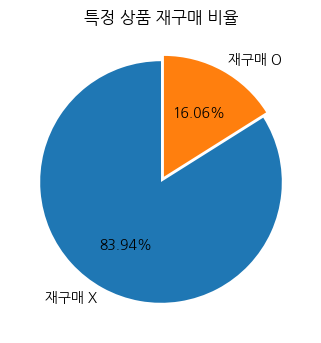

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.pie(repurseg_df['Repurchase_seg'].value_counts(), labels = ['재구매 X', '재구매 O'],
       startangle=90, autopct = '%.2f%%', explode = [0,0.05])
ax.set_title('특정 상품 재구매 비율')
fig.show()

### 6) 일자별 첫 구매자 수

In [ ]:
# Basic query
sql_q(
    "SELECT CUSTOMERID,\
    MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1;",
    conn
).head(10)

,CustomerID,MNDT
0,12347,2010-07-12
1,12350,2011-02-02
2,12352,2011-01-03
3,12359,2011-07-02
4,12373,2011-01-02
5,12383,2011-12-01
6,12386,2010-08-12
7,12388,2011-07-02
8,12393,2011-11-01
9,12395,2010-03-12


In [ ]:
# Result query
sql_q(
    "SELECT MNDT, COUNT(DISTINCT CUSTOMERID) BU\
    FROM\
    (SELECT CUSTOMERID,\
    MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1) BASE\
    GROUP BY MNDT;",
    conn
).head(10)

,MNDT,BU
0,2010-01-12,95
1,2010-02-12,93
2,2010-03-12,46
3,2010-05-12,69
4,2010-06-12,70
5,2010-07-12,50
6,2010-08-12,83
7,2010-09-12,67
8,2010-10-12,40
9,2010-12-12,31


### 7) 상품별 첫 구매 고객 수
- 신규 고객을 유치하기 위한 Hooking 상품 확인

In [ ]:
# Basic query
sql_q(
    "SELECT CUSTOMERID, STOCKCODE, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1, 2;",
    conn
).head(10)

,CustomerID,StockCode,MNDT
0,12347,20780,2010-07-12
1,12347,20782,2010-07-12
2,12347,21064,2010-07-12
3,12347,21171,2010-07-12
4,12347,21731,2010-07-12
5,12347,22195,2010-07-12
6,12347,22212,2010-07-12
7,12347,22375,2010-07-12
8,12347,22492,2010-07-12
9,12347,22494,2010-07-12


In [ ]:
# Processing query
sql_q(
    "SELECT *,\
    ROW_NUMBER() OVER(PARTITION BY CUSTOMERID ORDER BY MNDT) RNK\
    FROM \
    (SELECT CUSTOMERID, STOCKCODE, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1, 2) BASE\
    ;",
    conn
).head(10)

,CUSTOMERID,STOCKCODE,MNDT,RNK
0,12347,20780,2010-07-12,1
1,12347,20782,2010-07-12,2
2,12347,21064,2010-07-12,3
3,12347,21171,2010-07-12,4
4,12347,21731,2010-07-12,5
5,12347,22195,2010-07-12,6
6,12347,22212,2010-07-12,7
7,12347,22375,2010-07-12,8
8,12347,22492,2010-07-12,9
9,12347,22494,2010-07-12,10


In [ ]:
sql_q(
    "SELECT STOCKCODE, COUNT(DISTINCT CUSTOMERID) FIRST_BU\
    FROM \
    (SELECT * \
    FROM\
    (SELECT *,\
    ROW_NUMBER() OVER(PARTITION BY CUSTOMERID ORDER BY MNDT) RNK\
    FROM \
    (SELECT CUSTOMERID, STOCKCODE, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1, 2) BASE) BASE2\
    WHERE RNK = 1) BASE3\
    GROUP BY 1\
    ORDER BY 2 DESC;",
    conn
).head(10)

,STOCKCODE,FIRST_BU
0,20685,34
1,20914,25
2,21034,22
3,20725,20
4,20749,18
5,15056BL,18
6,20712,16
7,16156S,16
8,10002,13
9,21733,12


### 8) 첫 구매 후 이탈 비중

In [ ]:
# Basic query
sql_q(
    "SELECT CUSTOMERID,\
    COUNT(DISTINCT INVOICEDATE) F_DATE\
    FROM DATASET3\
    GROUP BY 1;",
    conn
).head(10)

,CustomerID,F_DATE
0,12347,1
1,12350,1
2,12352,1
3,12359,2
4,12373,1
5,12383,1
6,12386,2
7,12388,1
8,12393,1
9,12395,2


#### (1) 고객별 이탈 비중

In [ ]:
# Result query
sql_q(
    "SELECT \
    SUM(CASE WHEN F_DATE = 1 THEN 1.0 ELSE 0.0 END) / SUM(1) BOUNC_RATE,\
    SUM(CASE WHEN F_DATE > 1 THEN 1.0 ELSE 0.0 END) / SUM(1) REMAIN_RATE\
    FROM\
    (SELECT CUSTOMERID,\
    COUNT(DISTINCT INVOICEDATE) F_DATE\
    FROM DATASET3\
    GROUP BY 1) BASE;",
    conn
)

,BOUNC_RATE,REMAIN_RATE
0,0.733728,0.266272


#### (2) 국가별 이탈 비중

In [ ]:
# Result query
sql_q(
    "SELECT COUNTRY, COUNT(DISTINCT CUSTOMERID) Number_of_C, SUM(TOTAL) TOTAL,\
    SUM(CASE WHEN F_DATE = 1 THEN 1.0 ELSE 0.0 END) / SUM(1) BOUNC_RATE,\
    SUM(CASE WHEN F_DATE > 1 THEN 1.0 ELSE 0.0 END) / SUM(1) REMAIN_RATE\
    FROM\
    (SELECT CUSTOMERID, COUNTRY, SUM(UNITPRICE*QUANTITY) TOTAL,\
    COUNT(DISTINCT INVOICEDATE) F_DATE\
    FROM DATASET3\
    GROUP BY 1) BASE\
    GROUP BY 1\
    ORDER BY 3 DESC, 2 DESC, 4;",
    conn
).head(10)

,COUNTRY,Number_of_C,TOTAL,BOUNC_RATE,REMAIN_RATE
0,United Kingdom,1073,757286.49,0.738117,0.261883
1,Australia,6,25302.42,0.666667,0.333333
2,Germany,25,21266.42,0.520000,0.480000
3,France,25,20302.02,0.760000,0.240000
4,Japan,4,13534.78,0.250000,0.750000
5,EIRE,2,11689.90,0.000000,1.000000
6,Spain,9,10353.68,0.777778,0.222222
7,Norway,3,5106.17,0.666667,0.333333
8,Finland,1,4969.22,1.000000,0.000000
9,Portugal,6,4646.82,0.666667,0.333333


### 9) 판매 수량이 20% 이상 증가한 상품 리스트(YTD)

In [ ]:
# Basic query - 2011년도 상품별 판매 수량
sql_q(
    "SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2011'\
    GROUP BY 1\
    ORDER BY 2 DESC;",
    conn
).head(10)

,StockCode,QTY
0,84077,6145
1,85123A,5738
2,85099B,3657
3,21108,3207
4,22469,3135
5,22616,3096
6,22693,2667
7,22492,2485
8,21175,2456
9,40016,2345


In [ ]:
# Basic query - 2010년도 상품별 판매 수량
sql_q(
    "SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2010'\
    GROUP BY 1\
    ORDER BY 2 DESC;",
    conn
).head(10)

,StockCode,QTY
0,84077,3888
1,22492,2294
2,22189,2155
3,22188,2126
4,85123A,1957
5,21915,1867
6,84950,1836
7,17096,1728
8,21212,1690
9,22328,1634


In [ ]:
# JOIN Talbe
sql_q(
    "SELECT *\
    FROM\
    (SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2011'\
    GROUP BY 1) A\
    LEFT JOIN \
    (SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2010'\
    GROUP BY 1) B\
    ON A.STOCKCODE = B.STOCKCODE\
    ORDER BY A.QTY DESC, B.QTY DESC;",
    conn
).head(10)

,STOCKCODE,QTY,STOCKCODE,QTY
0,84077,6145,84077,3888.0
1,85123A,5738,85123A,1957.0
2,85099B,3657,85099B,1494.0
3,21108,3207,21108,72.0
4,22469,3135,22469,1038.0
5,22616,3096,22616,1027.0
6,22693,2667,22693,24.0
7,22492,2485,22492,2294.0
8,21175,2456,21175,217.0
9,40016,2345,40016,246.0


In [ ]:
# 참조 VIEW 생성
c.execute(
    "CREATE VIEW IF NOT EXISTS Post_Pre_QTY AS\
    SELECT A.STOCKCODE A_CODE, A.QTY QTY_2011, B.QTY QTY_2010\
    FROM\
    (SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2011'\
    GROUP BY 1) A\
    LEFT JOIN \
    (SELECT STOCKCODE, SUM(QUANTITY) QTY\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE, 1, 4) = '2010'\
    GROUP BY 1) B\
    ON A.STOCKCODE = B.STOCKCODE\
    ORDER BY A.QTY DESC, B.QTY DESC;"
)

In [ ]:
sql_q(
    "SELECT * FROM Post_Pre_QTY",
    conn
).head(10)

,A_CODE,QTY_2011,QTY_2010
0,84077,6145,3888.0
1,85123A,5738,1957.0
2,85099B,3657,1494.0
3,21108,3207,72.0
4,22469,3135,1038.0
5,22616,3096,1027.0
6,22693,2667,24.0
7,22492,2485,2294.0
8,21175,2456,217.0
9,40016,2345,246.0


In [ ]:
# Result query
sql_q(
    "SELECT *\
    FROM\
    (SELECT A_CODE STOCKCODE, QTY_2011, QTY_2010,\
    (QTY_2011 + 0.0) / QTY_2010 - 1 QTY_INCRESE_RATE\
    FROM Post_Pre_QTY\
    ORDER BY 2 DESC, 4 DESC)\
    WHERE QTY_INCRESE_RATE >= 0.2 AND\
    QTY_2010 >= 10\
    ORDER BY 4 DESC;",
    conn
).head(10)

,STOCKCODE,QTY_2011,QTY_2010,QTY_INCRESE_RATE
0,22693,2667,24,110.125000
1,21108,3207,72,43.541667
2,22264,482,12,39.166667
3,85184C,527,14,36.642857
4,22378,581,16,35.312500
5,21986,1390,43,31.325581
6,48185,827,33,24.060606
7,16161P,601,25,23.040000
8,84821,288,12,23.000000
9,21621,665,31,20.451613


### 10) 주차별 매출액

In [ ]:
# Basic query - 2011
sql_q(
    "SELECT SUBSTR(INVOICEDATE, 1,4) YY, STRFTIME('%W', INVOICEDATE ) WK,\
    SUM(UNITPRICE * QUANTITY) SALES\
    FROM DATASET3\
    GROUP BY 1,2\
    ORDER BY 3 DESC;",
    conn
).head(10)

,YY,WK,SALES
0,2011,44,78868.24
1,2011,26,67498.48
2,2011,09,55039.05
3,2010,28,53795.31
4,2011,22,47814.72
5,2011,13,47562.24
6,2010,06,47316.53
7,2010,02,46376.49
8,2010,32,39248.82
9,2010,36,38231.90


### 11) 신규 / 기존 고객의 2011년 월별 매출액

In [ ]:
# Basic query
sql_q(
    "SELECT CUSTOMERID,\
    CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END NEW_EXI\
    FROM\
    (SELECT CUSTOMERID, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1) BASE",
    conn
).head(10)

,CUSTOMERID,NEW_EXI
0,12347,EXI
1,12350,NEW
2,12352,NEW
3,12359,NEW
4,12373,NEW
5,12383,NEW
6,12386,EXI
7,12388,NEW
8,12393,NEW
9,12395,EXI


In [ ]:
# JOIN Table
sql_q(
    "SELECT A.CUSTOMERID, NEW_EXI, INVOICEDATE, UNITPRICE, QUANTITY\
    FROM DATASET3 A\
    LEFT JOIN\
    (SELECT CUSTOMERID,\
    CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END NEW_EXI\
    FROM\
    (SELECT CUSTOMERID, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1) BASE) B\
    ON A.CUSTOMERID = B.CUSTOMERID\
    WHERE SUBSTR(INVOICEDATE,1,4) = '2011'",
    conn
).head(10)

,CustomerID,NEW_EXI,InvoiceDate,UnitPrice,Quantity
0,13313,NEW,2011-04-01,1.95,10
1,13313,NEW,2011-04-01,0.42,25
2,13313,NEW,2011-04-01,0.42,25
3,13313,NEW,2011-04-01,2.10,5
4,13313,NEW,2011-04-01,1.25,10
5,13313,NEW,2011-04-01,1.95,10
6,13313,NEW,2011-04-01,3.25,6
7,13313,NEW,2011-04-01,1.45,12
8,13313,NEW,2011-04-01,2.95,6
9,13313,NEW,2011-04-01,1.95,8


In [ ]:
# Result query
new_exi_df = sql_q(
    "SELECT NEW_EXI, SUBSTR(INVOICEDATE,1,7) MM, SUM(UNITPRICE*QUANTITY) SALES\
    FROM DATASET3 A\
    LEFT JOIN\
    (SELECT CUSTOMERID,\
    CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END NEW_EXI\
    FROM\
    (SELECT CUSTOMERID, MIN(INVOICEDATE) MNDT\
    FROM DATASET3\
    GROUP BY 1) BASE) B\
    ON A.CUSTOMERID = B.CUSTOMERID\
    WHERE SUBSTR(INVOICEDATE,1,4) = '2011'\
    GROUP BY 1,2\
    ORDER BY 2 ;",
    conn
)
new_exi_df.head(10)

,NEW_EXI,MM,SALES
0,EXI,2011-01,19928.44
1,NEW,2011-01,30079.93
2,EXI,2011-02,9937.08
3,NEW,2011-02,25895.14
4,EXI,2011-03,12883.04
5,NEW,2011-03,42156.01
6,EXI,2011-04,26207.82
7,NEW,2011-04,21354.42
8,EXI,2011-05,20255.72
9,NEW,2011-05,8547.91


In [ ]:
pivot_new_exi = new_exi_df.pivot_table(index='MM', columns='NEW_EXI')
pivot_new_exi.columns = ['EXI', 'NEW']
pivot_new_exi['TOTAL'] = pivot_new_exi.sum(axis=1)
pivot_new_exi

,EXI,NEW,TOTAL
MM,,,
2011-01,19928.44,30079.93,50008.37
2011-02,9937.08,25895.14,35832.22
2011-03,12883.04,42156.01,55039.05
2011-04,26207.82,21354.42,47562.24
2011-05,20255.72,8547.91,28803.63
2011-06,19847.03,27967.69,47814.72
2011-07,33943.47,33555.01,67498.48
2011-08,11627.85,24770.79,36398.64
2011-09,18012.70,15997.84,34010.54


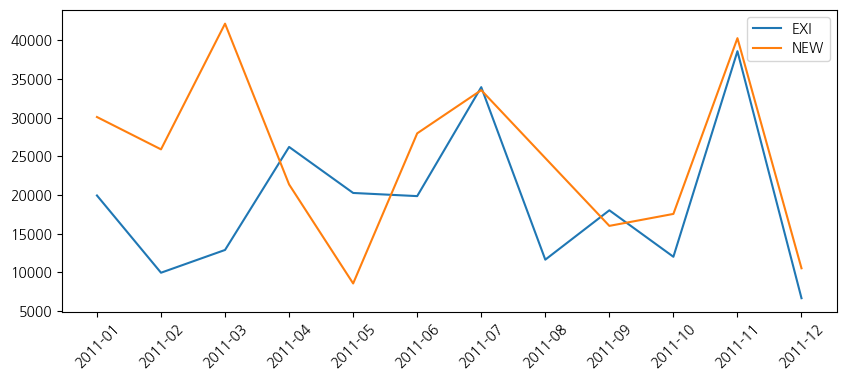

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pivot_new_exi.index, pivot_new_exi['EXI'], label = 'EXI')
ax.plot(pivot_new_exi.index, pivot_new_exi['NEW'], label = 'NEW')
ax.legend()
plt.xticks(rotation = 45)
fig.show()

### 12) 기존 고객의 2011년 월 누적 리텐션
- 2010년에 구매한 이력이 있는 고객들의 다음해 월별 리텐션

In [ ]:
# Basic query
sql_q(
    "SELECT CUSTOMERID\
    FROM DATASET3\
    GROUP BY 1\
    HAVING MIN(SUBSTR(INVOICEDATE,1,4)) = '2010'",
    conn
).head(10)

,CustomerID
0,12347
1,12386
2,12395
3,12427
4,12429
5,12431
6,12433
7,12441
8,12471
9,12472


In [ ]:
# Processing query
sql_q(
    "SELECT *\
    FROM DATASET3\
    WHERE CUSTOMERID IN\
    (SELECT CUSTOMERID\
    FROM DATASET3\
    GROUP BY 1\
    HAVING MIN(SUBSTR(INVOICEDATE,1,4)) = '2010')\
    AND SUBSTR(INVOICEDATE,1,4) = '2011';",
    conn
).head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDate
0,540002,21911,GARDEN METAL SIGN,12,1.65,16656,United Kingdom,2011-04-01
1,540002,22625,RED KITCHEN SCALES,8,8.50,16656,United Kingdom,2011-04-01
2,540002,21259,VICTORIAN SEWING BOX SMALL,24,4.95,16656,United Kingdom,2011-04-01
3,540002,21790,VINTAGE SNAP CARDS,144,0.72,16656,United Kingdom,2011-04-01
4,540004,84946,ANTIQUE SILVER TEA GLASS ETCHED,72,1.06,13094,United Kingdom,2011-04-01
5,540013,22794,SWEETHEART WIRE MAGAZINE RACK,1,7.95,16255,United Kingdom,2011-04-01
6,540013,22588,CARD HOLDER GINGHAM HEART,2,2.55,16255,United Kingdom,2011-04-01
7,540013,22961,JAM MAKING SET PRINTED,6,1.45,16255,United Kingdom,2011-04-01
8,540013,22585,PACK OF 6 BIRDY GIFT TAGS,5,1.25,16255,United Kingdom,2011-04-01
9,540013,21080,SET/20 RED RETROSPOT PAPER NAPKINS,5,0.85,16255,United Kingdom,2011-04-01


In [ ]:
# 참조 VIEW 생성
c.execute(
    "CREATE VIEW IF NOT EXISTS EXI_RETENTION AS\
    SELECT *\
    FROM DATASET3\
    WHERE CUSTOMERID IN\
    (SELECT CUSTOMERID\
    FROM DATASET3\
    GROUP BY 1\
    HAVING MIN(SUBSTR(INVOICEDATE,1,4)) = '2010')\
    AND SUBSTR(INVOICEDATE,1,4) = '2011';"
)

In [ ]:
# Processing query
exi_ret_df = sql_q(
    "SELECT MM, COUNT(CUSTOMERID) N_CUSTOMER\
    FROM\
    (SELECT CUSTOMERID, SUBSTR(MIN(INVOICEDATE), 1, 7) MM\
    FROM EXI_RETENTION\
    GROUP BY 1\
    ORDER BY 2, 1) BASE\
    GROUP BY 1;",
    conn
)
exi_ret_df.head(12)

,MM,N_CUSTOMER
0,2011-01,38
1,2011-02,25
2,2011-03,26
3,2011-04,29
4,2011-05,17
5,2011-06,17
6,2011-07,23
7,2011-08,8
8,2011-09,16
9,2011-10,13


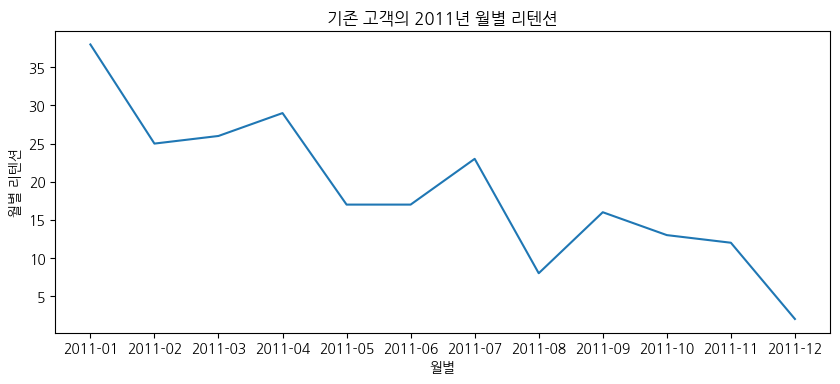

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(exi_ret_df['MM'], exi_ret_df['N_CUSTOMER'])
plt.xlabel('월별')
plt.ylabel('월별 리텐션')
plt.title('기존 고객의 2011년 월별 리텐션')
plt.savefig('월별리텐션.png')
plt.show()

In [ ]:
plus_ret = [sum(exi_ret_df['N_CUSTOMER'][:i+1]) for i in range(len(exi_ret_df))]
plus_ret

exi_ret_df['TOTAL'] = plus_ret
exi_ret_df.head(12)

,MM,N_CUSTOMER,TOTAL
0,2011-01,38,38
1,2011-02,25,63
2,2011-03,26,89
3,2011-04,29,118
4,2011-05,17,135
5,2011-06,17,152
6,2011-07,23,175
7,2011-08,8,183
8,2011-09,16,199
9,2011-10,13,212


In [ ]:
sql_q(
    "SELECT COUNT(M_R) FROM\
    (SELECT COUNT(CUSTOMERID) M_R, SUBSTR(INVOICEDATE,1,7) MM\
    FROM\
    (SELECT * FROM DATASET3\
    WHERE CUSTOMERID IN\
    (SELECT CUSTOMERID FROM DATASET3\
    GROUP BY CUSTOMERID\
    HAVING SUBSTR(MIN(INVOICEDATE),1,4) = '2010')\
    AND SUBSTR(INVOICEDATE,1,4)='2010') BASE\
    GROUP BY CUSTOMERID, 2) BASE2;", conn
)

,COUNT(M_R)
0,750


In [ ]:
sql_q(
    "SELECT COUNT(DISTINCT CUSTOMERID) FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE,1,4) = '2010';",conn
)

,COUNT(DISTINCT CUSTOMERID)
0,644


In [ ]:
exi_ret_df['누적 리텐션'] = round(exi_ret_df['TOTAL'] / 644 * 100, 2)
exi_ret_df.head(12)

,MM,N_CUSTOMER,TOTAL,누적 리텐션
0,2011-01,38,38,5.90
1,2011-02,25,63,9.78
2,2011-03,26,89,13.82
3,2011-04,29,118,18.32
4,2011-05,17,135,20.96
5,2011-06,17,152,23.60
6,2011-07,23,175,27.17
7,2011-08,8,183,28.42
8,2011-09,16,199,30.90
9,2011-10,13,212,32.92


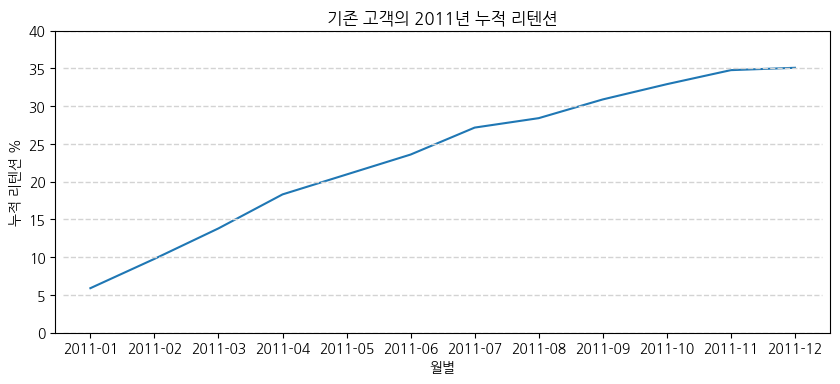

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(exi_ret_df['MM'], exi_ret_df['누적 리텐션'])
ax.set_title('기존 고객의 2011년 누적 리텐션')
ax.set_yticks(range(0,41,5))
ax.set_ylabel('누적 리텐션 %')
for i in range(0, 41, 5):
  ax.axhline(i, 0.01, 0.99, color='lightgray', linestyle='--', linewidth=1)
ax.set_xlabel('월별')
fig.savefig('누적리텐션.png')
fig.show()

- 누적 리텐션의 기울기에 큰 변화가 없는 것으로 보아, 기존 고객들은 특정 월에 구매를 몰아서 하지 않는 것을 확인할 수 있으며, 2010년 고객중 약 35%가 2011년 12월까지 구매를 한 것으로 확인된다.

### 13) LTV
- AMV = 전체 매출액 / 구매 고개수
- Retention Rate = 과거(t0) ~ 현재(t1) 고객 수 / 현재 고객 수
- 미래(t2)의 예상 매출액 = t1 고객수 * Retention Rate * AMV(t1)

In [ ]:
# 2011년도 Retention Rate
sql_q(
    "SELECT COUNT(B.CUSTOMERID) REMAIN_2010, COUNT(A.CUSTOMERID) TOTAL_2011,\
    (COUNT(B.CUSTOMERID) + 0.0) / COUNT(A.CUSTOMERID) RETENTION_RATE\
    FROM\
    (SELECT DISTINCT CUSTOMERID\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE,1,4)='2010') A\
    LEFT JOIN\
    (SELECT DISTINCT CUSTOMERID\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE,1,4)='2011') B\
    ON A.CUSTOMERID = B.CUSTOMERID;",
    conn
).head()

,REMAIN_2010,TOTAL_2011,RETENTION_RATE
0,226,644,0.350932


In [ ]:
# 2011년도 SALES, 구매자, AMV
sql_q(
    "SELECT\
    SUM(UNITPRICE*QUANTITY) SALES_2011,\
    COUNT(DISTINCT CUSTOMERID) N_BU,\
    (SUM(UNITPRICE*QUANTITY) + 0.0) / COUNT(DISTINCT CUSTOMERID) AMV\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE,1,4) = '2011';",
    conn
)

,SALES_2011,N_BU,AMV
0,528535.41,765,690.895961


In [ ]:
# Result query
sql_q(
    "SELECT N_BU * 0.35 E_N_BU_2012,\
    N_BU * 0.35 * AMV E_SALES_2012,\
    N_BU * 0.35 * AMV + SALES_2011 T_SALES_2012,\
    (N_BU * 0.35 * AMV + SALES_2011) / N_BU LTV_2012\
    FROM\
    (SELECT\
    SUM(UNITPRICE*QUANTITY) SALES_2011,\
    COUNT(DISTINCT CUSTOMERID) N_BU,\
    (SUM(UNITPRICE*QUANTITY) + 0.0) / COUNT(DISTINCT CUSTOMERID) AMV\
    FROM DATASET3\
    WHERE SUBSTR(INVOICEDATE,1,4) = '2011') BASE;",
    conn
)

,E_N_BU_2012,E_SALES_2012,T_SALES_2012,LTV_2012
0,267.75,184987.3935,713522.8035,932.709547


- 2012년 예상 구매자 : 약 267명 (2011년 구매자 * Retention Rate)

- 2011년 구매자 중 2012년에도 구매할 것으로 예상되는 인원의 총 매출액 : 약 184,987<br/>(2011년 구매자 * Retention Rate * AMV)

- 2011년 구매자 전체의 2012년까지의 LTV : 약 713,522<br/>(2011년 매출액 + 2011년 구매자의 2012년 예상 매출액)

- 2011년 구매자 개인의 2012년까지의 LTV : 약 932


In [ ]:
conn.close()